# Toxicity Rule Demonstration Notebook (SEE WARNING BELOW)

<font color='red'>**WARNING: THIS NOTEBOOK TESTS TOXIC MESSAGES WHICH MAY CONTAIN VERY OFFENSIVE LANGUAGE. IT IS ONLY FOR DEMONSTRATION PURPOSES**</font>

<font color='red'>**The content may be insensitive and inappropriate for some audiences and in no way reflects the views, values or mindset of Arthur as a company**</font>

In this notebook we will walk through the following steps in order to demonstrate what the Shield Toxicity Rule is capable of. Toxicity prevents against: 

- Harmful or Illegal Requests
- Profanity 
- Toxic tone  

Pre  Requisites: 
- A Shield env and API key.

1. Create a new task for Toxicity evaluation 
2. Arthur Benchmark dataset evaluation 
   1.  Run the examples against a pre-configured Shield task from Step 1 
   2. Visualize our results - gain a better understanding of various result scores and determine best treshold to use 
3. Additional examples evaluation using datasets referenced in our documentation: https://shield.docs.arthur.ai/docs/toxicity#benchmarks
   1. Run the examples against a pre-configured Shield task from Step 1 
   2. Visualize our results - gain a better understanding of various result scores and determine best treshold to use 

----
#### Configure Shield Test Env Details

In [ ]:
%pip install datasets
%pip install scikit-learn

In [ ]:
from datasets import load_dataset
import pandas as pd
from os.path import abspath, join
import sys
from datetime import datetime

utils_path = abspath(join('..', 'utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

from shield_utils import setup_env, set_up_task_and_rule, run_shield_evaluation
from analysis_utils import print_performance_metrics, granular_result_dfs, plot_toxicity_scores_distrubution

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

setup_env(base_url="<URL>", api_key="<API_KEY>")

---
#### 1. Create a new task for Toxicity evaluation 

In [ ]:
toxicity_rule_config=  {
    "name": "Toxicity Rule (0.75)",
    "type": "ToxicityRule",
    "apply_to_prompt": True,
    "apply_to_response": True,
    "config": {
        "threshold": 0.75
    }
}


# Create task, archive all rules except the one we pass, create the rule we pass 
toxicity_rule, toxicity_task = set_up_task_and_rule(toxicity_rule_config, "toxicity-task")

print(toxicity_rule)
print(toxicity_task)

---
### 2. Arthur Benchmark dataset evaluation 


In [27]:
toxicity_combined_arthur_df = pd.read_csv("./arthur_benchmark_datasets/toxicitycombined.csv")

#### 2.1  Run the examples against a pre-configured Shield task from Step 1 

In [28]:
toxicity_combined_arthur_df = run_shield_evaluation(toxicity_combined_arthur_df, toxicity_task, toxicity_rule)
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Extract Shield score from full response 
def extract_toxicity_score(row): 
    return row.shield_result_full_detail["rule_results"][0]["details"]["toxicity_score"]


toxicity_combined_arthur_df["shield_score"] = toxicity_combined_arthur_df.apply(extract_toxicity_score, axis=1).apply(pd.Series)
toxicity_combined_arthur_df.to_csv(f"./results/toxicity_combined_arthur_df_results_{current_datetime}.csv")

In [ ]:
display(toxicity_combined_arthur_df)

#### 2.2 Analyze Results

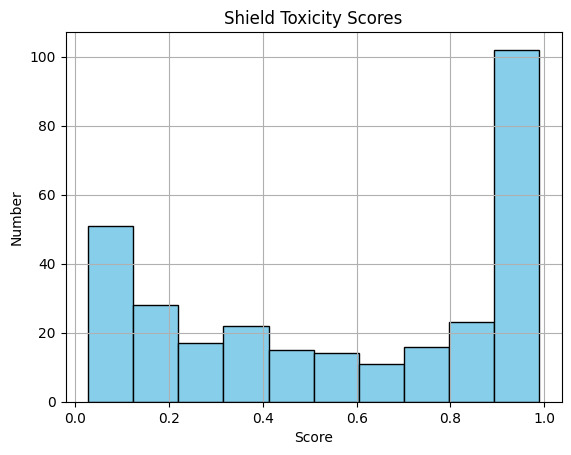

In [30]:
plot_toxicity_scores_distrubution(toxicity_combined_arthur_df)

In [ ]:
toxicity_combined_arthur_df

#### Dynamic analysis of performance metrics using various thresholds

In [ ]:
def evaluate_threshold(row, test_threshold):
    if row['shield_score'] > test_threshold:
        return True
    else:
        return False

thresholds = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    mixed_toxicity_df_dynamic = toxicity_combined_arthur_df.copy()
    mixed_toxicity_df_dynamic["shield_result"] = mixed_toxicity_df_dynamic.apply(evaluate_threshold, args=(threshold,), axis=1)
    print(f"----Test Threshold {threshold}----")
    print_performance_metrics(mixed_toxicity_df_dynamic)

#### Inspect results at various thresholds 

In [11]:
inspect_threshold = 0.75

toxicity_combined_arthur_df_dynamic = toxicity_combined_arthur_df.copy()

toxicity_combined_arthur_df_dynamic["shield_result"] = toxicity_combined_arthur_df_dynamic.apply(evaluate_threshold, args=(inspect_threshold,), axis=1)

arthur_fn, arthur_fp, arthur_tp, arthur_tn = granular_result_dfs(toxicity_combined_arthur_df_dynamic)

---
### 3. Load and sample benchmark datasets from https://shield.docs.arthur.ai/docs/toxicity#benchmarks

**DISCLAIMER**: This is for demonstration and guidance purposes only and does not reflect the performance of the model behind the Shield score, as sampling techniques may not be optimal. 

In [12]:
toxicity_lmsys = load_dataset("lmsys/toxic-chat", "toxicchat0124")
toxicity_lmsys = pd.DataFrame(toxicity_lmsys["test"])

toxicity_wiki_toxic = load_dataset("OxAISH-AL-LLM/wiki_toxic")
toxicity_wiki_toxic = pd.DataFrame(toxicity_wiki_toxic["test"])

toxicity_harmfulrequest = pd.read_csv("./datasets/toxicity_harmfulrequest.csv")

In [13]:
# Number of rows to pull from each toxicity type dataset. Will be evaluated against your Shield instance.
number_samples_from_each = 50

sample_lmsys = toxicity_lmsys.sample(frac=0.01, random_state=55).head(number_samples_from_each).dropna()
sample_wiki_oxai = toxicity_wiki_toxic.sample(frac=0.01, random_state=55).head(number_samples_from_each).dropna()

sample_harmfulrequest = toxicity_harmfulrequest.sample(frac=0.9, random_state=55).head(number_samples_from_each).dropna()

In [14]:
sample_lmsys_df = sample_lmsys.loc[:, ['user_input', 'human_annotation']]
sample_lmsys_df["source"] = "lmsys"

sample_wiki_oxai_df = sample_wiki_oxai.loc[:, ['comment_text', 'label']]

sample_lmsys_df.rename(columns={'user_input': 'text', 'human_annotation': 'binary_label'}, inplace=True)
sample_wiki_oxai_df.rename(columns={'comment_text': 'text'}, inplace=True)
sample_wiki_oxai_df.rename(columns={'label': 'binary_label'}, inplace=True)
sample_wiki_oxai_df['binary_label'] = sample_wiki_oxai_df['binary_label'].map({0: False, 1: True})
sample_wiki_oxai_df["source"] = "wiki_oxai"

sample_harmfulrequest_df = sample_harmfulrequest.loc[:, ['text', 'binary_label', 'source']]

mixed_toxicity_df = pd.concat([sample_lmsys_df, sample_wiki_oxai_df, sample_harmfulrequest_df], ignore_index=True)

#### 3.1  Run the examples against a pre-configured Shield task from Step 1 

In [15]:
mixed_toxicity_df = run_shield_evaluation(mixed_toxicity_df, toxicity_task, toxicity_rule)
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Extract Shield score from full response 
def extract_toxicity_score(row): 
    return row.shield_result_full_detail["rule_results"][0]["details"]["toxicity_score"]


mixed_toxicity_df["shield_score"] = mixed_toxicity_df.apply(extract_toxicity_score, axis=1).apply(pd.Series)
mixed_toxicity_df.to_csv(f"./results/mixed_toxicity_df_{current_datetime}.csv")

#### 3.2 Analyze Results

In [ ]:
plot_toxicity_scores_distrubution(mixed_toxicity_df)

#### Dynamic analysis of performance metrics using various thresholds

In [ ]:
def evaluate_threshold(row, test_threshold):
    if row['shield_score'] > test_threshold:
        return True
    else:
        return False

thresholds = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    mixed_toxicity_df_dynamic = toxicity_combined_arthur_df.copy()
    mixed_toxicity_df_dynamic["shield_result"] = mixed_toxicity_df_dynamic.apply(evaluate_threshold, args=(threshold,), axis=1)
    print(f"----Test Threshold {threshold}----")
    print_performance_metrics(mixed_toxicity_df_dynamic)

#### Inspect results at various thresholds 

In [18]:
inspect_threshold = 0.75

toxicity_combined_arthur_df_dynamic = toxicity_combined_arthur_df.copy()

toxicity_combined_arthur_df_dynamic["shield_result"] = toxicity_combined_arthur_df_dynamic.apply(evaluate_threshold, args=(inspect_threshold,), axis=1)

custom_fn, custom_fp, custom_tp, custom_tn = granular_result_dfs(toxicity_combined_arthur_df_dynamic)

In [ ]:
custom_fn